<a href="https://colab.research.google.com/github/ahatesham02/Bangla-Image-Captioning/blob/main/Bancap_%2B_Bornon_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!unzip -qq Flickr8k_Dataset.zip

In [4]:
! pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 1.3 MB 70.9 MB/s 
     |████████████████████████████████| 1.0 MB 65.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
import bnlp
from bnlp.corpus import  punctuations, letters, digits

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

## BanCap Dataset

In [7]:
data_bancap = pd.read_csv('/content/drive/MyDrive/Thesis/Flicker8k Bangla/BAN-Cap_captiondata.csv')

In [8]:
data_bancap.head(15)

,caption_id,english_caption,bengali_caption
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...
5,1001773457_577c3a7d70.jpg#0,A black dog and a spotted dog are fighting,একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে
6,1001773457_577c3a7d70.jpg#1,A black dog and a tri-colored dog playing with...,একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্...
7,1001773457_577c3a7d70.jpg#2,A black dog and a white dog with brown spots a...,একটি কালো কুকুর ও একটি সাদা-বাদামি ছোপযুক্ত কু...
8,1001773457_577c3a7d70.jpg#3,Two dogs of different breeds looking at each o...,ভিন্ন জাতের দুটি কুকুর রাস্তায় একে অপরের দিকে...
9,1001773457_577c3a7d70.jpg#4,Two dogs on pavement moving toward each other .,রাস্তার পাশে দুইটি কুকুর পরস্পরের দিকে এগিয়ে য...


In [9]:
def create_vocabulary(data):
  vocab = []
  for captions in data.bengali_caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [10]:
vocabulary = create_vocabulary(data_bancap)

Vocabulary Size : 17351


In [11]:
table = str.maketrans('', '', punctuations)
desc = [w.translate(table) for w in data_bancap.bengali_caption]

In [12]:
def cleaning(row):
  text = re.sub('[^\u0980-\u09FF]',' ', row) 
  return text

In [13]:
data_bancap['bengali_caption'] = data_bancap.bengali_caption.apply(cleaning)

In [14]:
data_bancap.head()

,caption_id,english_caption,bengali_caption
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...


In [15]:
data_bancap.drop(['english_caption'], axis =1, inplace= True)

In [16]:
data_bancap

,caption_id,bengali_caption
0,1000268201_693b08cb0e.jpg#0,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg#1,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg#2,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে
3,1000268201_693b08cb0e.jpg#3,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg#4,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...
...,...,...
40450,997722733_0cb5439472.jpg#0,গোলাপী শার্টের একটি লোক একটি শিলার উপরে উঠেছিল
40451,997722733_0cb5439472.jpg#1,একজন মানুষ পাথরে চড়ছে অনেক উপরে
40452,997722733_0cb5439472.jpg#2,লাল শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢ...
40453,997722733_0cb5439472.jpg#3,লাল শার্টে একটি রক আরোহী


In [17]:
clean_vocabulary = create_vocabulary(data_bancap)

Vocabulary Size : 15660


In [18]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir1 = '/content/Flicker8k_Dataset'
images_bancap = listdir(image_dir1)

In [19]:
def clean(col):
  text = col.split('#')[0]
  return text

In [20]:
data1 = data_bancap.copy()

In [21]:
data1['caption_id'] = data1.caption_id.apply(lambda x : x.split('#')[0])

In [22]:
data1.head(15)

,caption_id,bengali_caption
0,1000268201_693b08cb0e.jpg,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে
3,1000268201_693b08cb0e.jpg,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...
5,1001773457_577c3a7d70.jpg,একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে
6,1001773457_577c3a7d70.jpg,একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্...
7,1001773457_577c3a7d70.jpg,একটি কালো কুকুর ও একটি সাদা বাদামি ছোপযুক্ত কু...
8,1001773457_577c3a7d70.jpg,ভিন্ন জাতের দুটি কুকুর রাস্তায় একে অপরের দিকে...
9,1001773457_577c3a7d70.jpg,রাস্তার পাশে দুইটি কুকুর পরস্পরের দিকে এগিয়ে য...


In [23]:
data1.shape

(40455, 2)

In [24]:
data1.rename(columns = {'bengali_caption':'caption', 'caption_id':'filename'}, inplace = True)

In [25]:
data1.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে
3,1000268201_693b08cb0e.jpg,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...


In [26]:

# saving the dataframe
data1.to_csv('Bancap_preprocessed.csv')

## Bornon Dataset

In [27]:
import zipfile
exfile= '/content/drive/MyDrive/Thesis/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [28]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir2 = '/content/Bornon Images'
images_bornon = listdir(image_dir2)

## The location of the caption file
descriptions_dir2= '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images_bornon)))

The number of jpg flies in Bornon: 4106


In [29]:
text = load_doc(descriptions_dir2)
print(text[:387])

1.jpg#0    একটি পার্কে একটি লেক আছে ।
1.jpg#0    লেকের উপর একটি ব্রীজ আছে ।
1.jpg#0    গাছপালায় ঘেরা এই পার্কটি খুবই মনমুগ্ধকর ।
1.jpg#0    লেকের উপর একটি ব্রীজ আছে ।
1.jpg#0    পানির উপর আকাশের প্রতিচ্ছবি দেখা যাচ্ছে ।
2.jpg#0    একজন মানুষ মাথায় খড় নিয়ে হেটে যাচ্ছে ।
2.jpg#0    একজন মানুষ ও দু'টি খড়ের স্তূপ দেখা যাচ্ছে ।
2.jpg#0    লুঙ্গি পড়া একজন মানুষ খড়ের উপর হেটে যাচ্ছে ।


In [30]:
name = []
caption =[]
for sentences in text.split('\n'):
    splitted = sentences.split('#')
    w = splitted[0]
    name.append(w)
    cap = splitted[1].split(' ', 1)[1]
    caption.append(cap)

In [31]:
hr_lst  = list (zip(name, caption))
hr_lst

[('1.jpg', '   একটি পার্কে একটি লেক আছে ।'),
 ('1.jpg', '   লেকের উপর একটি ব্রীজ আছে ।'),
 ('1.jpg', '   গাছপালায় ঘেরা এই পার্কটি খুবই মনমুগ্ধকর ।'),
 ('1.jpg', '   লেকের উপর একটি ব্রীজ আছে ।'),
 ('1.jpg', '   পানির উপর আকাশের প্রতিচ্ছবি দেখা যাচ্ছে ।'),
 ('2.jpg', '   একজন মানুষ মাথায় খড় নিয়ে হেটে যাচ্ছে ।'),
 ('2.jpg', "   একজন মানুষ ও দু'টি খড়ের স্তূপ দেখা যাচ্ছে ।"),
 ('2.jpg', '   লুঙ্গি পড়া একজন মানুষ খড়ের উপর হেটে যাচ্ছে ।'),
 ('2.jpg', '   দুটি খড়ের স্তূপের পেছনে অনেক গাছপালা আছে ।'),
 ('2.jpg', '   অনেক গাছপালার সামনে দুটি খড়ের স্তূপ আছে ।'),
 ('3.jpg', '   টেবিলের উপর একটি চশমা আছে ।'),
 ('3.jpg', '   টেবিলের উপর একটি পানির গ্লাস ও একটি চশমা আছে ।'),
 ('3.jpg', '   একটি রুমে একটি খাট ও দুটি জানালা আছে  আছে ।'),
 ('3.jpg',
  '   টেবিলের উপর একটি গ্লাস ঢাকনা দিয়ে ঢেকে রাখা আছে এবং পাশে একটি চশমা আছে ।'),
 ('3.jpg',
  '   একটি রুমে একটি খাট এবং একটি টেবিল আছে,টেবিলের উপর পানির গ্লাস ও চশমা আছে ।'),
 ('4.jpg', '   একটি শিশু দেখা যাচ্ছে ।'),
 ('4.jpg', '   একটি শিশু গ্রা

In [32]:
data_bornon = pd.DataFrame(hr_lst, columns = ['filename', 'caption'])

data_bornon.head(15)

,filename,caption
0,1.jpg,একটি পার্কে একটি লেক আছে ।
1,1.jpg,লেকের উপর একটি ব্রীজ আছে ।
2,1.jpg,গাছপালায় ঘেরা এই পার্কটি খুবই মনমুগ্ধকর ।
3,1.jpg,লেকের উপর একটি ব্রীজ আছে ।
4,1.jpg,পানির উপর আকাশের প্রতিচ্ছবি দেখা যাচ্ছে ।
5,2.jpg,একজন মানুষ মাথায় খড় নিয়ে হেটে যাচ্ছে ।
6,2.jpg,একজন মানুষ ও দু'টি খড়ের স্তূপ দেখা যাচ্ছে ।
7,2.jpg,লুঙ্গি পড়া একজন মানুষ খড়ের উপর হেটে যাচ্ছে ।
8,2.jpg,দুটি খড়ের স্তূপের পেছনে অনেক গাছপালা আছে ।
9,2.jpg,অনেক গাছপালার সামনে দুটি খড়ের স্তূপ আছে ।


In [33]:
desc = [w.translate(table) for w in data_bornon.caption]

In [34]:
data_bornon['caption'] = data_bornon.caption.apply(cleaning) 

In [35]:
def create_vocabulary2(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [36]:
clean_vocabulary = create_vocabulary2(data_bornon)

Vocabulary Size : 5281


In [37]:
data_bornon.head(15)

,filename,caption
0,1.jpg,একটি পার্কে একটি লেক আছে
1,1.jpg,লেকের উপর একটি ব্রীজ আছে
2,1.jpg,গাছপালায় ঘেরা এই পার্কটি খুবই মনমুগ্ধকর
3,1.jpg,লেকের উপর একটি ব্রীজ আছে
4,1.jpg,পানির উপর আকাশের প্রতিচ্ছবি দেখা যাচ্ছে
5,2.jpg,একজন মানুষ মাথায় খড় নিয়ে হেটে যাচ্ছে
6,2.jpg,একজন মানুষ ও দু টি খড়ের স্তূপ দেখা যাচ্ছে
7,2.jpg,লুঙ্গি পড়া একজন মানুষ খড়ের উপর হেটে যাচ্ছে
8,2.jpg,দুটি খড়ের স্তূপের পেছনে অনেক গাছপালা আছে
9,2.jpg,অনেক গাছপালার সামনে দুটি খড়ের স্তূপ আছে


In [38]:
# saving the dataframe
data_bornon.to_csv('Bornon_preprocessed.csv')

In [39]:
data2 = data_bornon.copy()

## Merged Dataset

In [40]:
data3 = pd.concat([data1, data2], axis=0)
data3.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,1000268201_693b08cb0e.jpg,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,1000268201_693b08cb0e.jpg,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে
3,1000268201_693b08cb0e.jpg,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,1000268201_693b08cb0e.jpg,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...


In [41]:
print(data1.shape)
print(data2.shape)

(40455, 2)
(17439, 2)


In [42]:
data3.shape

(57894, 2)

In [43]:
clean_vocabulary = create_vocabulary2(data3)

Vocabulary Size : 18071


## Preprocess Image Data

In [44]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in data1["filename"]:
      full_image_path1 = image_dir1+"/"+ filenames
      img_name_vector.append(full_image_path1)
  for filenames in data2["filename"]:
      full_image_path2 = image_dir2+"/"+ filenames  
      img_name_vector.append(full_image_path2)

  return img_name_vector
img_name_vector = preprocess_images(data3)
len(img_name_vector)

57894

In [45]:
 len(img_name_vector)

57894

In [46]:
img_name_vector[40450:40465]

['/content/Flicker8k_Dataset/997722733_0cb5439472.jpg',
 '/content/Flicker8k_Dataset/997722733_0cb5439472.jpg',
 '/content/Flicker8k_Dataset/997722733_0cb5439472.jpg',
 '/content/Flicker8k_Dataset/997722733_0cb5439472.jpg',
 '/content/Flicker8k_Dataset/997722733_0cb5439472.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/2.jpg',
 '/content/Bornon Images/2.jpg',
 '/content/Bornon Images/2.jpg',
 '/content/Bornon Images/2.jpg',
 '/content/Bornon Images/2.jpg']

In [47]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data3["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data3)
total_captions[:10]

['<start> একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে  <end>',
 '<start> একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে <end>',
 '<start> একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   <end>',
 '<start> ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে <end>',
 '<start> গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে  <end>',
 '<start> একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে <end>',
 '<start> একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্তায় খেলছে  <end>',
 '<start> একটি কালো কুকুর ও একটি সাদা বাদামি ছোপযুক্ত কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে  <end>',
 '<start> ভিন্ন জাতের দুটি কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে <end>',
 '<start> রাস্তার পাশে দুইটি কুকুর পরস্পরের দিকে এগিয়ে যাচ্ছ  <end>']

In [48]:
len(total_captions)

57894

In [49]:
from pickle import dump

# save to file
dump(total_captions, open('bengali_captions_merged1.pkl', 'wb'))
dump(img_name_vector, open('bengali_img_names_merged1.pkl', 'wb'))

In [3]:
train_captions = load(open('/content/drive/MyDrive/Thesis/Bancap + Bornon/bengali_captions_merged1.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/Thesis/Bancap + Bornon/bengali_img_names_merged1.pkl', 'rb'))

In [4]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [5]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [6]:
import tensorflow as tf

###Image Reshaping 

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [8]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [9]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [10]:
for img in img_name_vector[50000:50005] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)


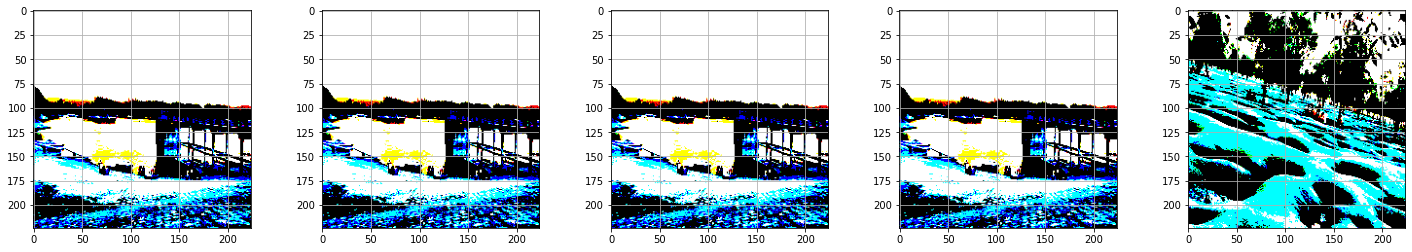

In [11]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

Shape after resize : (224, 224, 3)


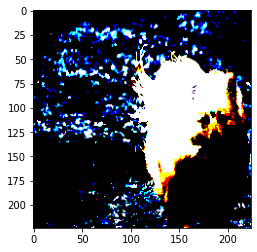

In [12]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

## Load Pretrained Model

In [13]:
modelres = ResNet50(include_top=True,weights='imagenet')

In [14]:
modelres.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
image_model = ResNet50(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [16]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

## Tokenizer and Vocabulary

In [17]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [18]:
vocab_size = len(tokenizer.index_word)+1

In [19]:
vocab_size

18076

In [20]:
len(train_captions)

57894

In [21]:
train_captions[50000:50005]

['<start>    জলাশয়ে একটি ব্রীজ আছে   <end>',
 '<start>    জলাশয়ের পাড়ে কয়েকটি নৌকা আছে   <end>',
 '<start>    কয়েকজন মানুষ আছে   <end>',
 '<start>    অনেকগুলো গাছপালা আছে   <end>',
 '<start>    একটি অসমতল মাঠে ঘাস আছে   <end>']

In [22]:
train_seqs[:3]

[[2, 4, 202, 53, 29, 36, 42, 4, 750, 1275, 913, 874, 214, 161, 3],
 [2, 4, 42, 40, 4, 131, 6862, 3813, 3],
 [2, 4, 36, 25, 131, 4223, 161, 3]]

In [23]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'একটি',
 5: 'আছে',
 6: 'একজন',
 7: 'কুকুর',
 8: 'যাচ্ছে',
 9: 'লোক',
 10: 'এক',
 11: 'দেখা',
 12: 'এবং',
 13: 'করছে',
 14: 'সাদা',
 15: 'উপর',
 16: 'কালো',
 17: 'বসে',
 18: 'দুটি',
 19: 'কিছু',
 20: 'মহিলা',
 21: 'রঙের',
 22: 'লাল',
 23: 'ও',
 24: 'খেলছে',
 25: 'তার',
 26: 'ছেলে',
 27: 'ছোট',
 28: 'দিয়ে',
 29: 'পরা',
 30: 'নীল',
 31: 'পাশে',
 32: 'মধ্যে',
 33: 'দাঁড়িয়ে',
 34: 'পরিহিত',
 35: 'মানুষ',
 36: 'বাচ্চা',
 37: 'সামনে',
 38: 'করে',
 39: 'নিয়ে',
 40: 'শিশু',
 41: 'ব্যক্তি',
 42: 'মেয়ে',
 43: 'ছবি',
 44: 'দিকে',
 45: 'দিচ্ছে',
 46: 'ধরে',
 47: 'থেকে',
 48: 'লাফ',
 49: 'সবুজ',
 50: 'দাঁড়িয়ে',
 51: 'দৌড়াচ্ছে',
 52: 'দিয়ে',
 53: 'জামা',
 54: 'পরে',
 55: 'ঘাসের',
 56: 'সাথে',
 57: 'কুকুরটি',
 58: 'বল',
 59: 'পানিতে',
 60: 'বাদামী',
 61: 'হলুদ',
 62: 'নিয়ে',
 63: 'রয়েছে',
 64: 'মেয়ে',
 65: 'দুই',
 66: 'জন্য',
 67: 'মাঠে',
 68: 'একদল',
 69: 'পোশাক',
 70: 'উপরে',
 71: 'হাতে',
 72: 'বালক',
 73: 'অনেক',
 74: 'এর',
 75: 'মুখে',
 76: 'আছেন',

In [24]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(57894, 34)


In [25]:
cap_vector

array([[  2,   4, 202, ...,   0,   0,   0],
       [  2,   4,  42, ...,   0,   0,   0],
       [  2,   4,  36, ...,   0,   0,   0],
       ...,
       [  2, 257,  32, ...,   0,   0,   0],
       [  2, 257,  10, ...,   0,   0,   0],
       [  2, 243,  15, ...,   0,   0,   0]], dtype=int32)

## Creating Dataset

In [26]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [27]:
path_train, path_test, caption_train, caption_test = train_test_split(img_name_vector, cap_vector, test_size = 0.1, random_state = 42)

In [28]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 52104
Testing data for images: 5790
Training data for Captions: 52104
Testing data for Captions: 5790


In [29]:
from tqdm import tqdm

In [30]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 181/181 [01:14<00:00,  2.42it/s]


In [31]:
batch_features.shape

TensorShape([59, 7, 7, 2048])

In [32]:
batch_features_flattened

<tf.Tensor: shape=(59, 49, 2048), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [33]:
batch_feat.shape

TensorShape([49, 2048])

In [34]:
len(img_features)

11579

In [35]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [36]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [37]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [38]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 34)


In [39]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE 
EPOCHS = 20
max_length = 25
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [40]:
feature_shape

2048

In [41]:
vocab_size

18076

In [42]:
attention_feature_shape

49

## CNN Encoder

In [43]:
from keras.utils.vis_utils import plot_model

In [44]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [45]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [46]:
encoder=Encoder(embedding_dim)

## Attention Model

In [47]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

## Decoder

In [48]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [49]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [50]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 18076)
Attention weights shape from Decoder: (64, 49, 1)


In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [52]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [53]:
checkpoint_path = "/content/model_merged_resnet/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [54]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [55]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [56]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [57]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [58]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.295, & test loss is 1.082
Time taken for 1 epoch 239.41226434707642 sec

Test loss has been reduced from 100.000 to 1.082


  3%|▎         | 1/30 [04:00<1:56:07, 240.26s/it]

For epoch: 2, the train loss is 0.974, & test loss is 0.916
Time taken for 1 epoch 126.23639273643494 sec

Test loss has been reduced from 1.082 to 0.916


  7%|▋         | 2/30 [06:07<1:21:00, 173.57s/it]

For epoch: 3, the train loss is 0.848, & test loss is 0.806
Time taken for 1 epoch 126.06176614761353 sec

Test loss has been reduced from 0.916 to 0.806


 10%|█         | 3/30 [08:13<1:08:28, 152.17s/it]

For epoch: 4, the train loss is 0.754, & test loss is 0.717
Time taken for 1 epoch 125.99889969825745 sec

Test loss has been reduced from 0.806 to 0.717


 13%|█▎        | 4/30 [10:20<1:01:35, 142.13s/it]

For epoch: 5, the train loss is 0.679, & test loss is 0.650
Time taken for 1 epoch 126.01847338676453 sec

Test loss has been reduced from 0.717 to 0.650


 17%|█▋        | 5/30 [12:27<56:54, 136.57s/it]  

For epoch: 6, the train loss is 0.617, & test loss is 0.592
Time taken for 1 epoch 126.15137815475464 sec

Test loss has been reduced from 0.650 to 0.592


 20%|██        | 6/30 [14:34<53:18, 133.28s/it]

For epoch: 7, the train loss is 0.566, & test loss is 0.546
Time taken for 1 epoch 126.02074813842773 sec

Test loss has been reduced from 0.592 to 0.546


 23%|██▎       | 7/30 [16:40<50:15, 131.13s/it]

For epoch: 8, the train loss is 0.523, & test loss is 0.507
Time taken for 1 epoch 125.89188313484192 sec

Test loss has been reduced from 0.546 to 0.507


 27%|██▋       | 8/30 [18:47<47:32, 129.68s/it]

For epoch: 9, the train loss is 0.486, & test loss is 0.478
Time taken for 1 epoch 125.88095903396606 sec

Test loss has been reduced from 0.507 to 0.478


 30%|███       | 9/30 [20:54<45:03, 128.73s/it]

For epoch: 10, the train loss is 0.453, & test loss is 0.444
Time taken for 1 epoch 125.98418021202087 sec

Test loss has been reduced from 0.478 to 0.444


 33%|███▎      | 10/30 [23:00<42:42, 128.10s/it]

For epoch: 11, the train loss is 0.425, & test loss is 0.415
Time taken for 1 epoch 125.87703394889832 sec

Test loss has been reduced from 0.444 to 0.415


 37%|███▋      | 11/30 [25:07<40:24, 127.63s/it]

For epoch: 12, the train loss is 0.398, & test loss is 0.388
Time taken for 1 epoch 126.02397084236145 sec

Test loss has been reduced from 0.415 to 0.388


 40%|████      | 12/30 [27:14<38:12, 127.35s/it]

For epoch: 13, the train loss is 0.374, & test loss is 0.370
Time taken for 1 epoch 125.85369205474854 sec

Test loss has been reduced from 0.388 to 0.370


 43%|████▎     | 13/30 [29:20<36:00, 127.10s/it]

For epoch: 14, the train loss is 0.353, & test loss is 0.345
Time taken for 1 epoch 125.93463826179504 sec

Test loss has been reduced from 0.370 to 0.345


 47%|████▋     | 14/30 [31:27<33:51, 126.95s/it]

For epoch: 15, the train loss is 0.334, & test loss is 0.330
Time taken for 1 epoch 125.9893250465393 sec

Test loss has been reduced from 0.345 to 0.330


 50%|█████     | 15/30 [33:33<31:42, 126.86s/it]

For epoch: 16, the train loss is 0.320, & test loss is 0.318
Time taken for 1 epoch 125.78222370147705 sec

Test loss has been reduced from 0.330 to 0.318


 53%|█████▎    | 16/30 [35:40<29:34, 126.75s/it]

For epoch: 17, the train loss is 0.305, & test loss is 0.309
Time taken for 1 epoch 125.9579701423645 sec

Test loss has been reduced from 0.318 to 0.309


 57%|█████▋    | 17/30 [37:47<27:27, 126.72s/it]

For epoch: 18, the train loss is 0.293, & test loss is 0.290
Time taken for 1 epoch 125.78428030014038 sec

Test loss has been reduced from 0.309 to 0.290


 60%|██████    | 18/30 [39:53<25:19, 126.64s/it]

For epoch: 19, the train loss is 0.282, & test loss is 0.279
Time taken for 1 epoch 125.96999335289001 sec

Test loss has been reduced from 0.290 to 0.279


 63%|██████▎   | 19/30 [42:00<23:13, 126.65s/it]

For epoch: 20, the train loss is 0.269, & test loss is 0.271
Time taken for 1 epoch 125.99292421340942 sec

Test loss has been reduced from 0.279 to 0.271


 67%|██████▋   | 20/30 [44:06<21:06, 126.66s/it]

For epoch: 21, the train loss is 0.257, & test loss is 0.261
Time taken for 1 epoch 125.97663927078247 sec

Test loss has been reduced from 0.271 to 0.261


 70%|███████   | 21/30 [46:13<19:00, 126.68s/it]

For epoch: 22, the train loss is 0.251, & test loss is 0.252
Time taken for 1 epoch 126.00799179077148 sec

Test loss has been reduced from 0.261 to 0.252


 73%|███████▎  | 22/30 [48:20<16:53, 126.69s/it]

For epoch: 23, the train loss is 0.240, & test loss is 0.243
Time taken for 1 epoch 126.02481293678284 sec

Test loss has been reduced from 0.252 to 0.243


 77%|███████▋  | 23/30 [50:26<14:46, 126.69s/it]

For epoch: 24, the train loss is 0.234, & test loss is 0.234
Time taken for 1 epoch 126.01455545425415 sec

Test loss has been reduced from 0.243 to 0.234


 80%|████████  | 24/30 [52:33<12:40, 126.70s/it]

For epoch: 25, the train loss is 0.227, & test loss is 0.224
Time taken for 1 epoch 126.01708173751831 sec

Test loss has been reduced from 0.234 to 0.224


 83%|████████▎ | 25/30 [54:40<10:33, 126.70s/it]

For epoch: 26, the train loss is 0.222, & test loss is 0.220
Time taken for 1 epoch 125.82588267326355 sec

Test loss has been reduced from 0.224 to 0.220


 87%|████████▋ | 26/30 [56:46<08:26, 126.65s/it]

For epoch: 27, the train loss is 0.219, & test loss is 0.219
Time taken for 1 epoch 125.89702796936035 sec

Test loss has been reduced from 0.220 to 0.219


 90%|█████████ | 27/30 [58:53<06:19, 126.63s/it]

For epoch: 28, the train loss is 0.212, & test loss is 0.206
Time taken for 1 epoch 125.90288639068604 sec

Test loss has been reduced from 0.219 to 0.206


 97%|█████████▋| 29/30 [1:03:06<02:06, 126.42s/it]

For epoch: 29, the train loss is 0.205, & test loss is 0.207
Time taken for 1 epoch 125.93990993499756 sec

For epoch: 30, the train loss is 0.200, & test loss is 0.202
Time taken for 1 epoch 125.85492587089539 sec

Test loss has been reduced from 0.206 to 0.202


100%|██████████| 30/30 [1:05:12<00:00, 130.42s/it]


In [59]:
ckpt_manager.checkpoints

['/content/model_merged_resnet/ckpt-25',
 '/content/model_merged_resnet/ckpt-26',
 '/content/model_merged_resnet/ckpt-27',
 '/content/model_merged_resnet/ckpt-28',
 '/content/model_merged_resnet/ckpt-29']

In [61]:
ckpt.restore('/content/model_merged_resnet/ckpt-29')

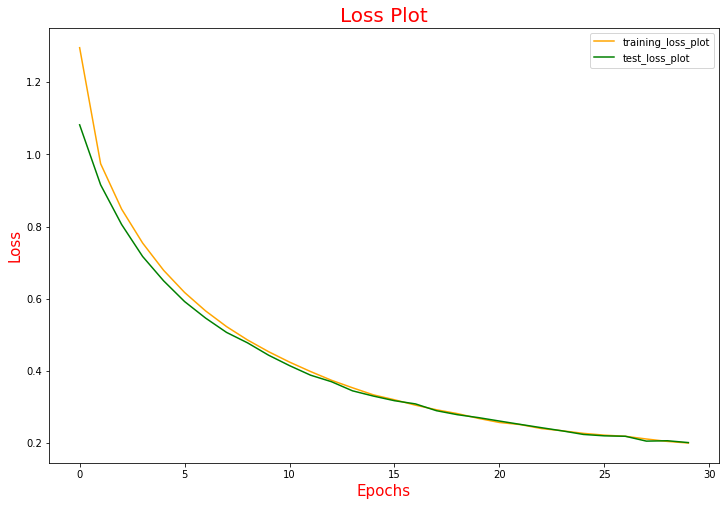

In [62]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [63]:
attention_feature_shape

49

In [64]:
attention_plot = np.zeros((max_length, attention_feature_shape))
attention_plot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [73]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (30, 30))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap])

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [67]:
from nltk.translate.bleu_score import sentence_bleu

In [68]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [69]:
image_test = path_test.copy()

In [70]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [71]:
encoder.save_weights('content/outputs_encoder')
decoder.save_weights('.content/outputs_decoder')

BLEU-1: 25.000000
BLEU-2: 18.898224
BLEU-3: 9.597590
BLEU-4: 7.122723
METEOR Score : 0.30241935483870974
Real Caption: এক মহিলা ও একটি কুকুর খেলছে
Prediction Caption: এক মহিলা তার পোষা কুকুরের সাথে খেলা করছে


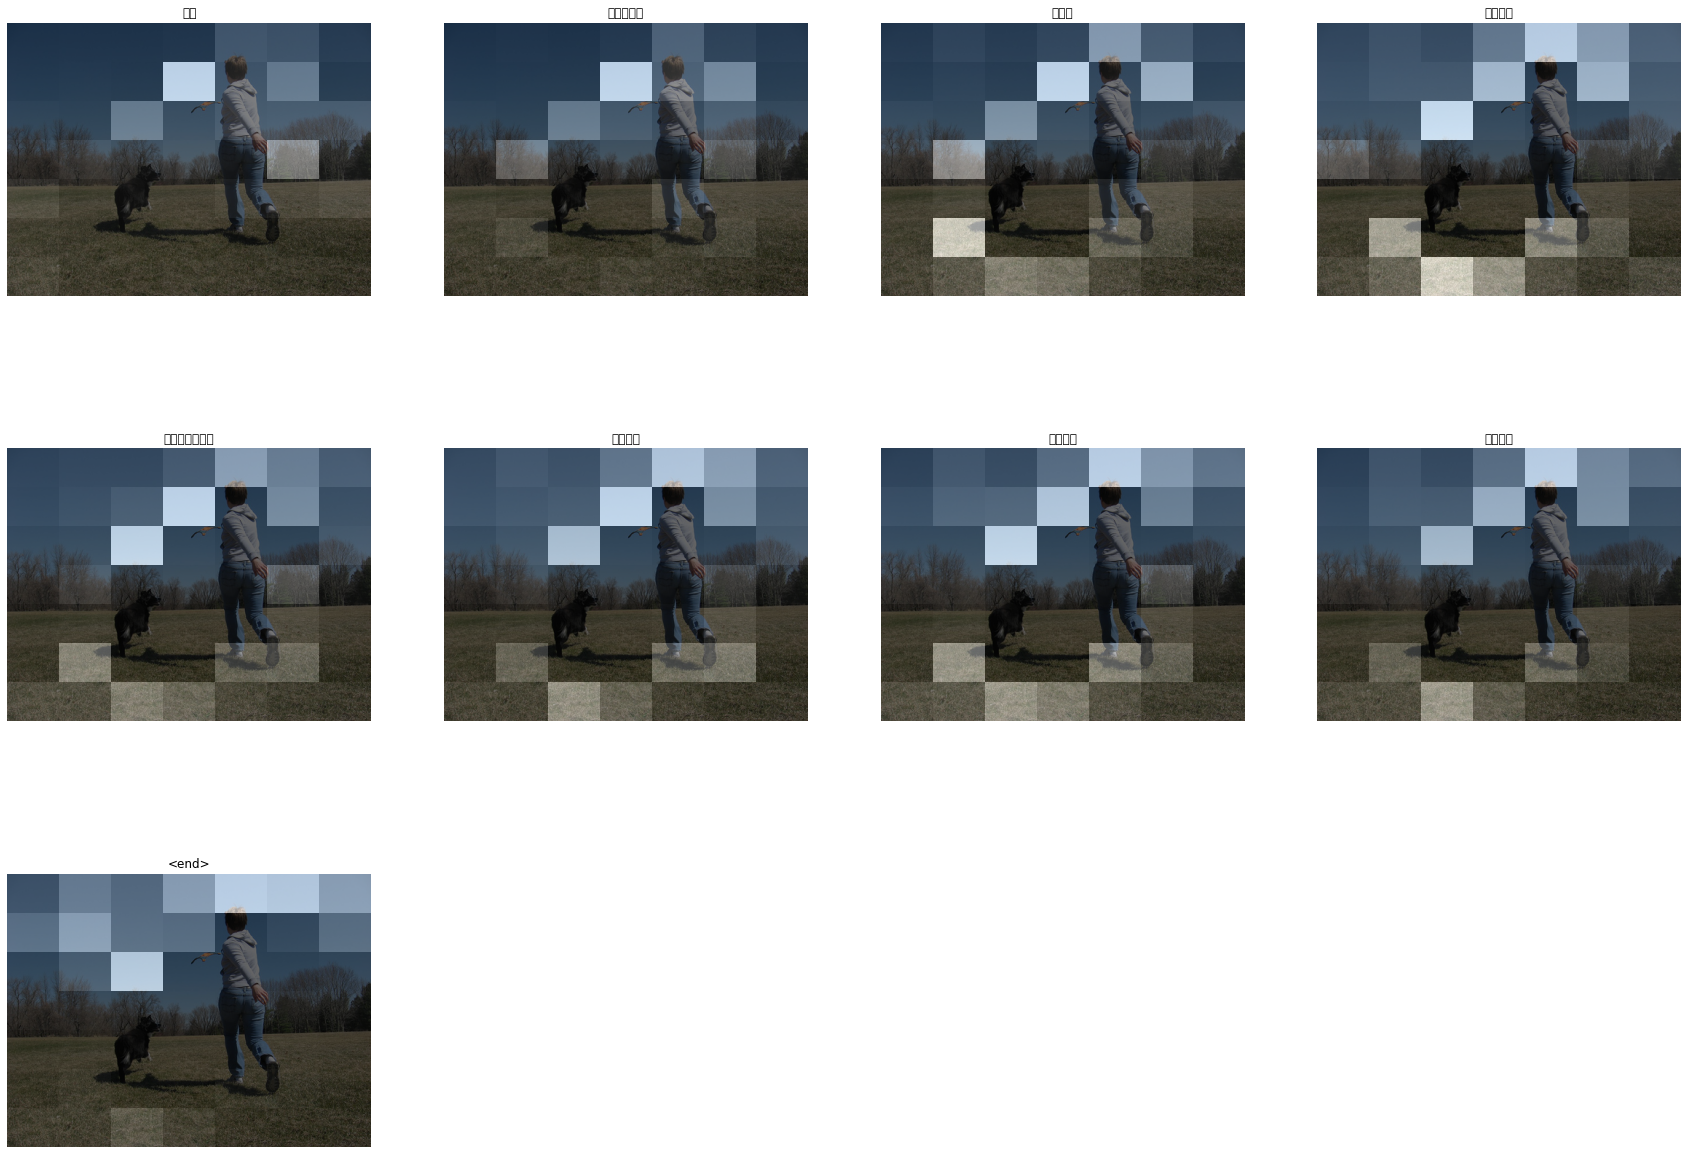

In [87]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('METEOR Score :',score)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)


## Meteor Score

In [78]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [79]:
from nltk.translate.meteor_score import meteor_score

In [80]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score = meteor_score(reference,candidate)
print(score)

0.996


In [81]:
b1=[]
b2=[]
b3=[]
b4=[]
m_score =[]

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  print(pred_caption)
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

Streaming output truncated to the last 5000 lines.
পার্কে তিনজন মানুষ স্কেটিং করছে
একজন লোক একটি ছাতার উপরে একটি বল ভারসাম্য বজায় রাখে
কাচের গ্লাসের সামনে একজন বৃদ্ধা চেয়ারে বসে আছেন
প্রাপ্তবয়স্ক ও নীল পোশাকে একদল বাচ্চা ছোট বাচ্চা বসে আছে
একটি শিশু পানির নিচে সাঁতার কাটা অবস্থায় এক ছেলে সাঁতার কাটা অবস্থায় এক ছেলে সাঁতার কাটা অবস্থায় এক ছেলে সাঁতার কাটা অবস্থায় এক ছেলে
ঔষধ গুলি গোল
কর্দমাক্ত কমলা গেঞ্জি পড়া এক লোক সাইকেল চালাচ্ছে
গোধূলি লগ্নে সূর্যাস্ত যাচ্ছে
দুটি কুকুর একটি মাঠে দৌড়াচ্ছে মানুষজন দেখছে
পানিতে এক লোক দৌড়ে যাচ্ছে
একজনের হাত আছে
দুইজন মানুষের ছবি দেখা যাচ্ছে
মোহাওক এবং দাড়িওয়ালা একজন লোক কালো জ্যাকেট পরে একটি হাত রেখে দূরত্বে তাকাচ্ছেন
একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের একটি খয়েরি রঙের
গাড়ীর উপর এক লোক এবং একজন লোক এবং একজন লোক এবং একজন লোক এবং একজন লোক এবং একজন লোক এবং একজন লোক এবং একজন
একটি কুকুর একটি কার এ ঘুমায়
একটি বিদ্যালয় আছে
একজন মহিলা একটি টেবিলে বসে কথা বলছে
ঘরের ভিতর দুটি কুক

In [82]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

BLEU-1: 57.160716
BLEU-2: 52.727808
BLEU-3: 48.895813
BLEU-4: 45.792234


In [83]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

Meteor Score of Bahdanau attention: 0.582126
